# Clean Example

In [13]:
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib import rc
rc("font", family = "serif",size=20)
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import cvxpy as cp
import numpy as np

from loss import *
from reg import *
from convergence import *
from utils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quadratically Regularized PCA 
No boolean features yet


Note that you don't need to standize the data if you use the Scaled loss function because this does it for you. Though this requires calculating the sigma_matrix

In [14]:
iris = datasets.load_iris()
A = iris.data
#list of colors for plotting
colors = np.array(['tab:blue','tab:orange','tab:green'])[iris.target]

#generate random missing data:
mask,missing_idx = gen_random_missing_mask(A,n_missing=35,return_indices=True)

In [15]:
#construct loss list
# for figuring out scaling use the unscaled version

loss_list_unscaled = [(np.arange(A.shape[1]),QuadraticLoss(mask=mask))]

mu_arr, sigma_arr = calc_mu_sigma(A,loss_list_unscaled)

#### Now define the new loss_list and regularizers + cvxpy problems

much of this should get wrapped into functions, left here to expose whats going on

In [16]:
loss_list = [(np.arange(A.shape[1]),ScaledQuadraticLoss(mask=mask))]

#define regularization functions
# here they are the same for X and Y, but in general can be different

regX = QuadraticReg()
regY = QuadraticReg()

#define K the number of dimension to project onto
k = 2

#Define cvxpy variables and parameters
m,n = A.shape
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)


#is there a better way to start these?
objX = cp.Constant(0)
objY = cp.Constant(0)

#define objectives + problems
for columns, loss_fxn in loss_list:
    objX += loss_fxn(A-mu_arr,Xv@Yp,columns,sigma_arr)       
    objY += loss_fxn(A-mu_arr,Xp@Yv,columns,sigma_arr)
if regX is not None:
    objX += regX(Xv)
if regY is not None:
    objY += regY(Yv)
objX = cp.Minimize(objX)
objY = cp.Minimize(objY)
probX = cp.Problem(objX)
probY = cp.Problem(objY)



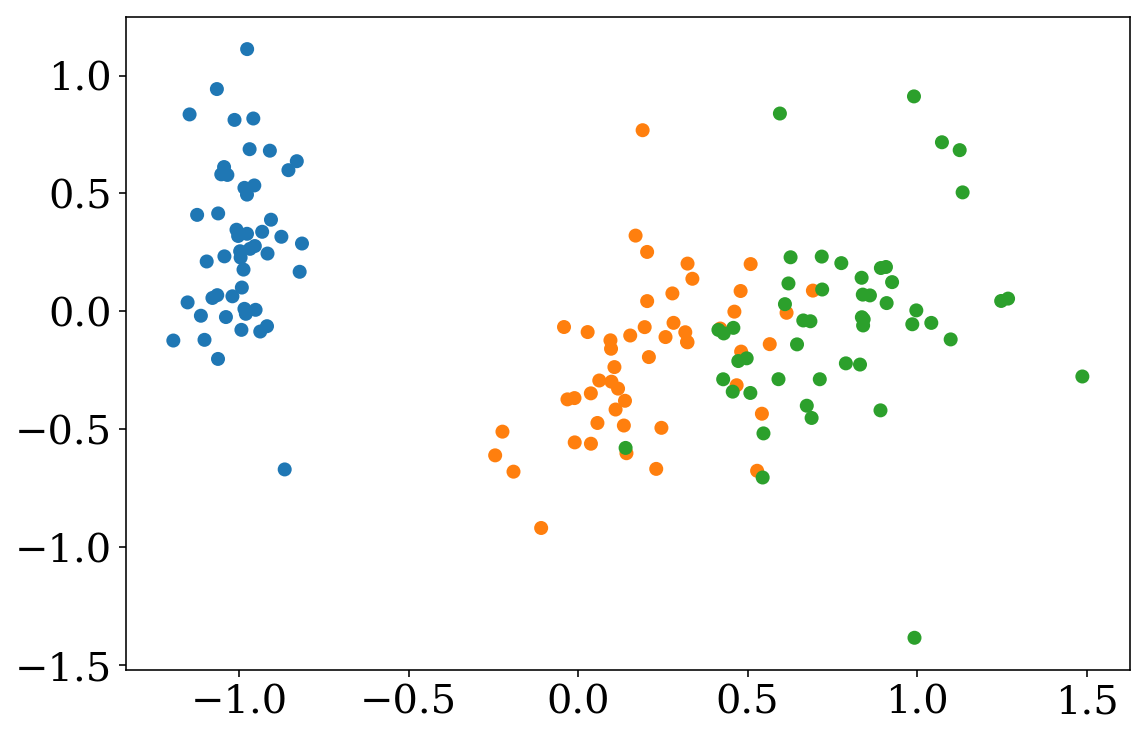

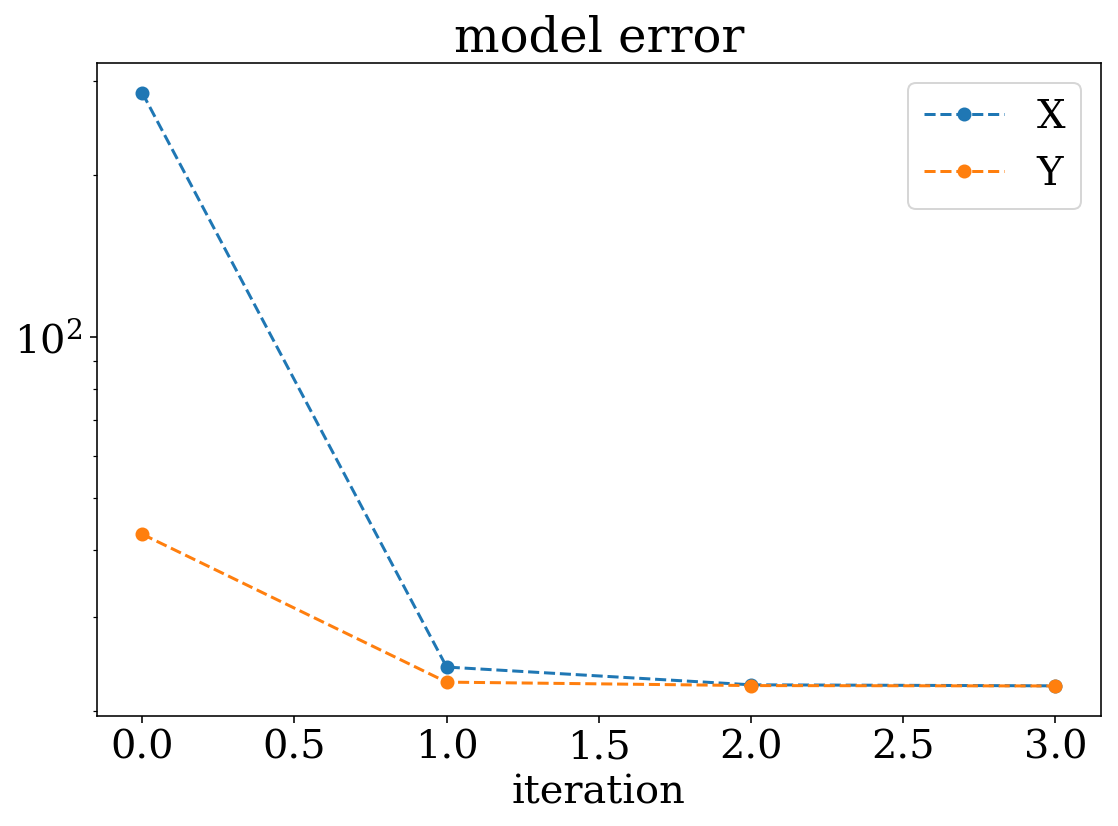

In [17]:
# solve the problem


convergence = Convergence()

while not convergence:
    convergence.append('x',probX.solve(verbose=False))
    Xp.value = Xv.value

    convergence.append('y',probY.solve())
    Yp.value = Yv.value
    
    
X = Xp.value
Y = Yp.value
Z = X @ Y
plt.scatter(X[:,0],X[:,1],color=colors)
plt.show()
convergence.plot()

### Impute the missing data points


I'm confused why i only need to add the mu_arr back to A_hat, i would have naively expected to need to multiply by the sigma_arr. Bug?

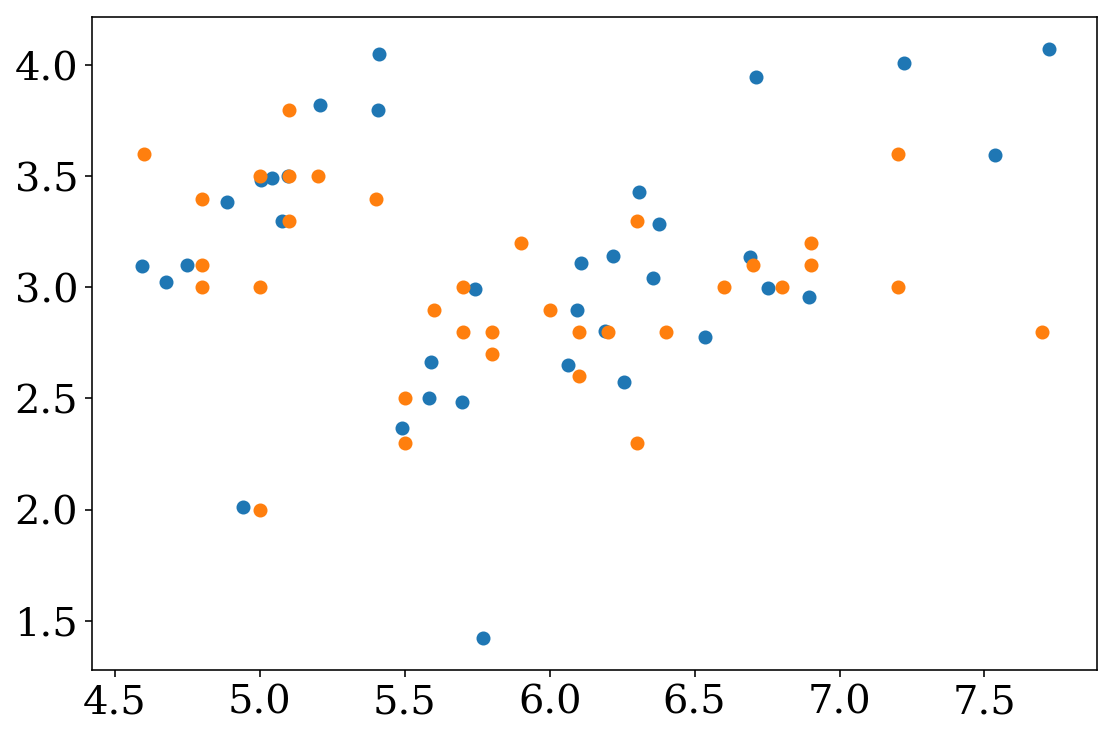

In [18]:

A_hat = X@Y
A_hat = A_hat+mu_arr
missing_imputed = A_hat[missing_idx[:,0]]
missing_true = A[missing_idx[:,0]]

plt.scatter(missing_imputed[:,0],missing_imputed[:,1])
plt.scatter(missing_true[:,0],missing_true[:,1])
# for i in range(len(missing_imputed)):
#     plt.plot([missing_imputed[i,0],missing_true[i,0]],[missing_imputed[i,1],missing_true[i,1]],'--')

In [19]:
# average distance in 4D that we missed by
np.sqrt(np.sum((missing_imputed-missing_true)**2,axis=1)).mean()

0.47503394221844053

# Now with more boolean features!

Basically exactly the same as above except that now will use the matrix Amix with a final column of booleans.

I make two of the classes true and one of them false. (the orange and blue classes are true and the the green one is false because I'm hoping this can induce greater separation in those classes.

Not use categoricals yet b/c who wants to spend their implementing loss functions :(


Need a new loss_list b/c now we have multiple data types

In [20]:
Amix = np.hstack([A,iris.target[:,None]])
idx = Amix[:,-1]<1.5
Amix[:,-1][idx]  =  1 #true
Amix[:,-1][~idx] = -1 #false


#generate random missing data:
mask_mix ,missing_idx_mix = gen_random_missing_mask(Amix,n_missing=35,return_indices=True)

In [21]:
loss_list_unscaled = [(np.arange(4),QuadraticLoss(mask_mix)), #continuous valued columns
                      (np.array([4]),HingeLoss(mask_mix))] # boolean columns

In [49]:
mu_arr, sigma_arr = calc_mu_sigma(Amix,loss_list_unscaled)

#you can make the boolean more important by dividing it.
#make it 3 to see much clearer separation of orange and green
sigma_arr[:,-1] /= 1



In [50]:
loss_list = [(np.arange(4),ScaledQuadraticLoss(mask=mask_mix)),
             (np.array([4]),ScaledHingeLoss(mask=mask_mix))]

#define regularization functions
# here they are the same for X and Y, but in general can be different

regX = QuadraticReg(nu=100)
regY = QuadraticReg()

#define K the number of dimension to project onto
k = 2

#Define cvxpy variables and parameters
m,n = Amix.shape
Xp = cp.Parameter((m,k))
Yp = cp.Parameter((k,n))

Xv = cp.Variable((m,k))
Yv = cp.Variable((k,n))
X0 = np.random.rand(m,k)



#Random Intialization 
Xv.value = np.random.rand(m,k)
Xp.value = np.random.rand(m,k)

Yp.value = np.random.rand(k,n)
Yv.value = np.random.rand(k,n)


#is there a better way to start these?
objX = cp.Constant(0)
objY = cp.Constant(0)

#define objectives + problems
for columns, loss_fxn in loss_list:
    objX += loss_fxn(Amix-mu_arr,Xv@Yp,columns,sigma_arr)       
    objY += loss_fxn(Amix-mu_arr,Xp@Yv,columns,sigma_arr)
if regX is not None:
    objX += regX(Xv)
if regY is not None:
    objY += regY(Yv)
objX = cp.Minimize(objX)
objY = cp.Minimize(objY)
probX = cp.Problem(objX)
probY = cp.Problem(objY)



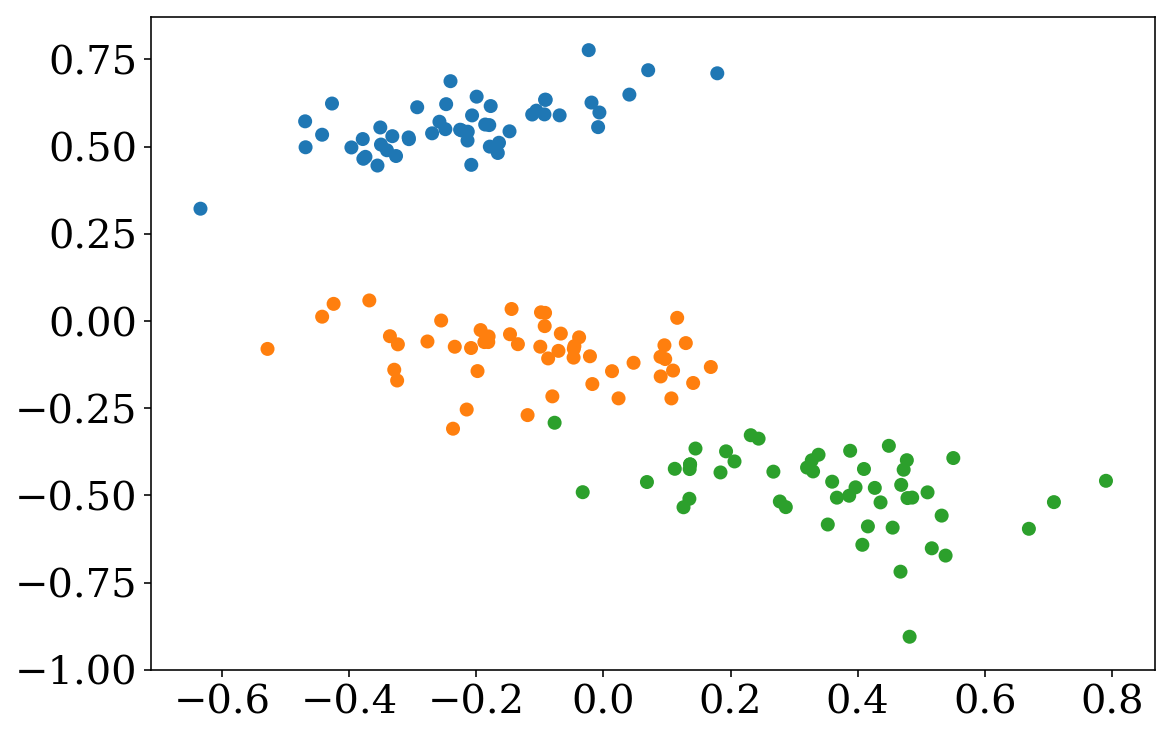

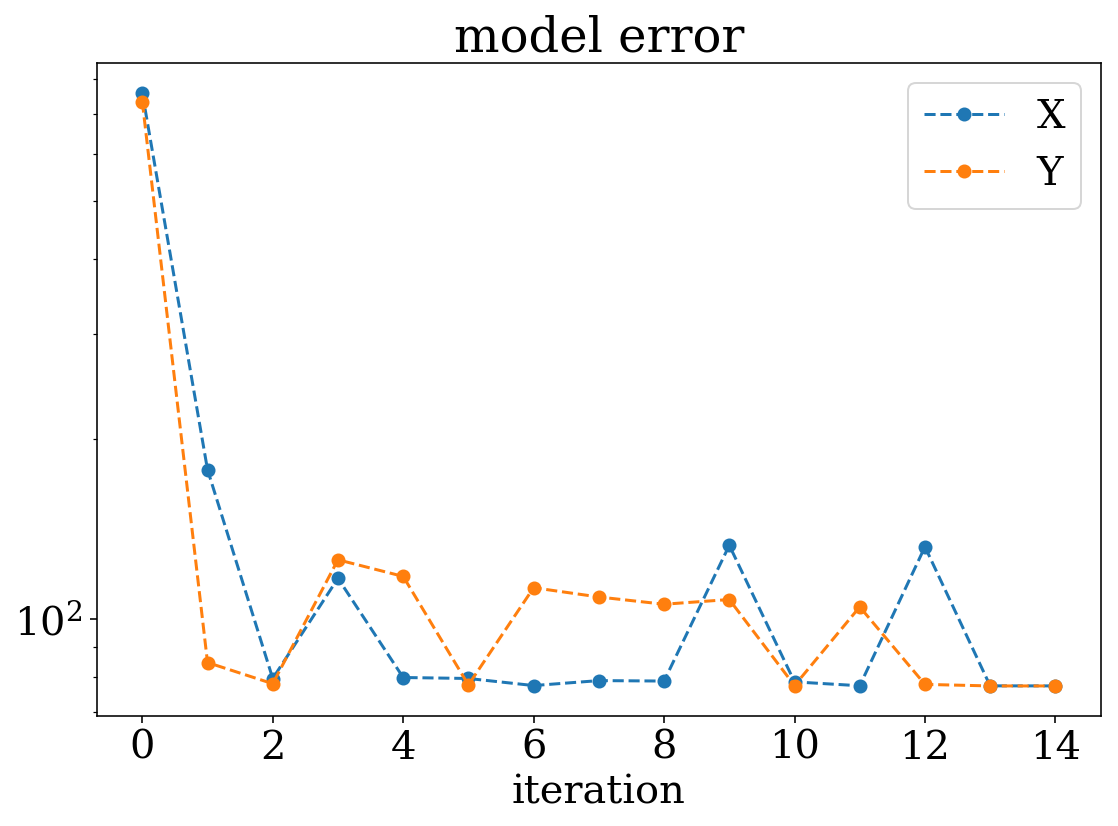

In [51]:
# solve the problem


convergence = Convergence()

while not convergence:
    convergence.append('x',probX.solve(verbose=False))
    Xp.value = Xv.value

    convergence.append('y',probY.solve())
    Yp.value = Yv.value
    
    
X = Xp.value
Y = Yp.value
Z = X @ Y
plt.scatter(X[:,0],X[:,1],color=colors)
plt.show()
convergence.plot(ylog=True)

This doesn't always end in an optimal place, any decent way to do better with that?

Maybe because Y is always evaulated second should just check for convergence in Y.

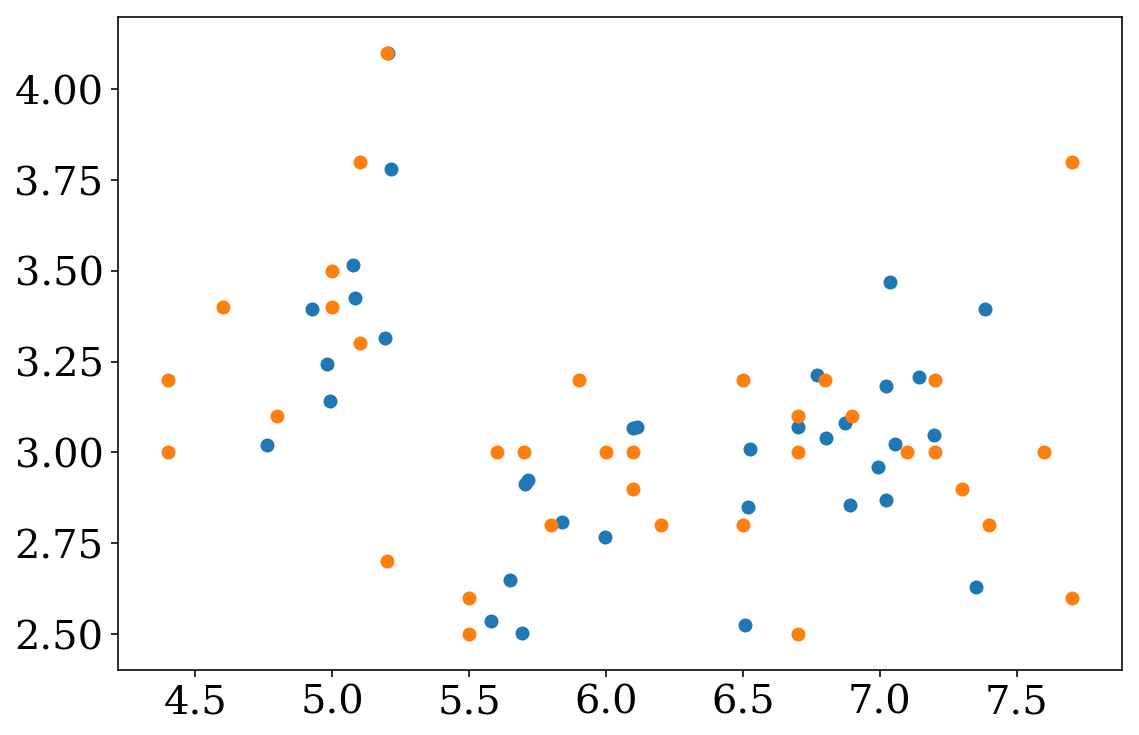

In [59]:

A_hat = X@Y
A_hat = A_hat+mu_arr
missing_imputed = A_hat[missing_idx_mix[:,0]]
missing_true = Amix[missing_idx_mix[:,0]]

plt.scatter(missing_imputed[:,0],missing_imputed[:,1])
plt.scatter(missing_true[:,0],missing_true[:,1])
# for i in range(len(missing_imputed)):
#     plt.plot([missing_imputed[i,0],missing_true[i,0]],[missing_imputed[i,1],missing_true[i,1]],'--')

In [74]:
# plt.hist(((A_hat-Amix)/Amix).flatten(),bins=35)